# Next steps for automated scoring
3 levels of system prompt:
1. **Generic** (no examples, no table description, "scalable"/généralisable)
2. **Table detail** (text typically written by consultant to describe the input table, still "scalable" / généralisable)
3. **Guided examples** (similar as before with example prompts being computed and appended in conversation history; dangerous, potentially not "scalable" / généralisable)

+ Compare across system prompts, temperature, etc. for V3_multitables --> 3 Digits only with 6 different scenarios (different numbers)

I am taking too many "opinionated" decisions where I make a certain hypothesis, but we don't actually know whether it's true, so we need to measure against a baseline without those hypotheses (like 5% tolerance for example, could work, but could be terribly wrong...)

In [19]:
import os
from openai import OpenAI
from IPython.display import Markdown, display

api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key=api_key, project="proj_XBK3SmQEgnxzAc3W3OPTIYZs")

# Function to display markdown text
def print_md(text):
    display(Markdown(text))

KeyboardInterrupt: 

In [ ]:
import pandas as pd
target = pd.read_csv('target/target_digit_integer_V3_multitables', sep=';')
exampleTargetDF = pd.read_csv('target/exampleTarget_digit_integer_V3_multitables', sep=';')

In [ ]:
exampleTargetDF

,examplePrompt,Complexité,Target Scenario1,Target Scenario2,Target Scenario3,Target Scenario4,Target Scenario5,Target Scenario6
0,What's the average basket in France?,1,10,9,12,9,10,10
1,Which country has the highest turnover?,2,Spain,Spain,Spain,Spain,Italy,Spain
2,List the country names in descending order per...,2,"Spain, France, Italy","Spain, France, Italy","Spain, Italy, France","Italy, Spain, France","France, Italy, Spain","Italy, Spain, France"
3,Does France have a higher generated turnover t...,2,No,Yes,Yes,No,No,No
4,What is the average number of units sold acros...,3,561.67,502.33,619.67,542.33,503.67,586.67


In [ ]:
def query_model(messages, temperature=0):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=temperature,
        max_tokens=25
    )
    return completion.choices[0].message.content

In [ ]:
# prompt idea with better description of table:
# A description of the dataset
dataset_description_EXAMPLE = """
You have a dataset about electric cars registered in Washington state, USA in 
2020. It is available as a pandas DataFrame named `electric_cars`.

Each row in the dataset represents the count of the number of cars 
registered within a city, for a particular model.

The dataset contains the following columns.

- `city` (character): The city in which the registered owner resides.
- `county` (character): The county in which the registered owner resides.
- `model_year` (integer): The [model year](https://en.wikipedia.org/wiki/Model_year#United_States_and_Canada) of the car.
- `make` (character): The manufacturer of the car.
- `model` (character): The model of the car.
- `electric_vehicle_type` (character): Either "Plug-in Hybrid Electric Vehicle (PHEV)" or "Battery Electric Vehicle (BEV)".
- `n_cars` (integer): The count of the number of vehicles registered.
"""

In [ ]:
dataset_description = """
You have a dataset about customer buying behaviour in different countries (France, Spain, Italy) in each row, with different KPIs (units_sold, purchasers, generated_turnover, average_basket) in each column.

The dataset contains the following columns.

- `units_sold` (integer): Number of units sold in the country.
- `purchasers` (integer): Number of purchasers in the country (purchasers is the same as client, or customer).
- `generated_turnover` (integer): All the revenue generated in that country.
- `average_basket` (integer): Average basket per purchaser in the country. It's calculated by dividing 'generated_turnover' with 'purchasers'.
"""

In [ ]:
# Optimal Prompts V3
systemPromptV3 = f"""
You are a data analyst assistant programmed to provide concise and specific answers based on the data presented, without additional explanation or detail. Follow these guidelines for responding:
- For numeric values, provide integers whenever possible, or round to two decimal places using a period (.) for decimals.
- For list or ranking requests, format the answer as a comma (,) seperated list, e.g., 'Spain, France, Italy'.
- For yes/no questions, respond with 'Yes' or 'No' only.
- Assume all questions are data-driven and require precise, direct responses based on the provided data.

Here is the table:
###
"""

In [ ]:
# Enhanced system prompt to emphasize the use of digits for numbers
systemPromptV3 = f"""
You are a data analyst assistant programmed to provide concise and specific answers based on the data presented, without additional explanation or detail. Follow these guidelines for responding:
- For numeric values, provide answers using digits (e.g., '4' instead of 'four'), and round to two decimal places using a period (.) for decimals when necessary.
- For list or ranking requests, format the answer as a comma-separated list, e.g., 'Spain, France, Italy'.
- For yes/no questions, respond with 'Yes' or 'No' only.
- Assume all questions are data-driven and require precise, direct responses based on the provided data.

Here is the table:
###
"""

In [ ]:
exampleTargetDF

,examplePrompt,Complexité,Target Scenario1,Target Scenario2,Target Scenario3,Target Scenario4,Target Scenario5,Target Scenario6
0,What's the average basket in France?,1,10,9,12,9,10,10
1,Which country has the highest turnover?,2,Spain,Spain,Spain,Spain,Italy,Spain
2,List the country names in descending order per...,2,"Spain, France, Italy","Spain, France, Italy","Spain, Italy, France","Italy, Spain, France","France, Italy, Spain","Italy, Spain, France"
3,Does France have a higher generated turnover t...,2,No,Yes,Yes,No,No,No
4,What is the average number of units sold acros...,3,561.67,502.33,619.67,542.33,503.67,586.67


Example message to help calculate tokens for each request:

MESSAGES:  [{'role': 'system', 'content': "\nYou are a data analyst assistant programmed to provide concise and specific answers based on the data presented, without additional explanation or detail. Follow these guidelines for responding:\n- For numeric values, provide integers whenever possible, or round to two decimal places using a period (.) for decimals.\n- For list or ranking requests, format the answer as a comma (,) seperated list, e.g., 'Spain, France, Italy'.\n- For yes/no questions, respond with 'Yes' or 'No' only.\n- Assume all questions are data-driven and require precise, direct responses based on the provided data.\n\nHere is the table:\n###\n        units_sold  purchasers  generated_turnover  average_basket\nFrance         407         373                4216              11\nSpain          544         398                5705              14\nItaly          648         482                6347              14"}, {'role': 'user', 'content': "What's the average basket in France?"}, {'role': 'assistant', 'content': '11'}, {'role': 'user', 'content': 'Which country has the highest turnover?'}, {'role': 'assistant', 'content': 'Italy'}, {'role': 'user', 'content': 'List the country names in descending order per number of purchasers?'}, {'role': 'assistant', 'content': 'Italy, Spain, France'}, {'role': 'user', 'content': 'Does France have a higher generated turnover than Italy?'}, {'role': 'assistant', 'content': 'No'}, {'role': 'user', 'content': 'What is the average number of units sold across all countries?'}, {'role': 'assistant', 'content': '533.0'}, {'role': 'user', 'content': 'How many clients are there in France?'}]

In [22]:
# New method with multiple system Prompt:
def generate_messages_type1(prompt, systemPromptV3, loaded_string):
    return [{"role": "system", "content": systemPromptV3 + loaded_string},
            {"role": "user", "content": prompt}]

def generate_messages_type2(prompt, systemPromptV3, loaded_string, dataset_description):
    return [{"role": "system", "content": systemPromptV3 + loaded_string + " " + dataset_description},
            {"role": "user", "content": prompt}]

def generate_messages_type3(prompt, systemPromptV3, loaded_string, exampleTargetDF, fileName):
    messages = [{"role": "system", "content": systemPromptV3 + loaded_string}]
    for i in range(5):
        messages.append({"role": "user", "content": exampleTargetDF["examplePrompt"][i]})
        messages.append({"role": "assistant", "content": exampleTargetDF[f"Target {fileName.replace('.txt', '')}"][i]})
    messages.append({"role": "user", "content": prompt})
    return messages

def generate_messages_type4(prompt, systemPromptV3, loaded_string, dataset_description, exampleTargetDF, fileName):
    messages = [{"role": "system", "content": systemPromptV3 + loaded_string + " " + dataset_description}]
    for i in range(5):
        messages.append({"role": "user", "content": exampleTargetDF["examplePrompt"][i]})
        messages.append({"role": "assistant", "content": exampleTargetDF[f"Target {fileName.replace('.txt', '')}"][i]})
    messages.append({"role": "user", "content": prompt})
    return messages

In [23]:
system_prompt_types = {
    "Generic": generate_messages_type1,
    "Table Detail": generate_messages_type2,
    "Guided Examples": generate_messages_type3,
    "Detail & Examples": generate_messages_type4
}
system_prompt_types

{'Generic': <function __main__.generate_messages_type1(prompt, systemPromptV3, loaded_string)>,
 'Table Detail': <function __main__.generate_messages_type2(prompt, systemPromptV3, loaded_string, dataset_description)>,
 'Guided Examples': <function __main__.generate_messages_type3(prompt, systemPromptV3, loaded_string, exampleTargetDF, fileName)>,
 'Detail & Examples': <function __main__.generate_messages_type4(prompt, systemPromptV3, loaded_string, dataset_description, exampleTargetDF, fileName)>}

In [20]:
# AMAZING!
directory = "data/multiTXT_integers_V3_multitables/"
files = os.listdir(directory)

# Define the DataFrame to store LLM responses
LLMresponse_columns = ["Prompt", "Temperature", "systemPrompt type"] + [f"Response {scenario}" for scenario in files]
LLMresponse = pd.DataFrame(columns=LLMresponse_columns)

tempList = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]

for temperature in tempList:
    for idx, prompt_row in target.iterrows():
        #if idx == 1:  # Stop after processing the first prompt
        #    break
        prompt = prompt_row['Prompt']
        
        for prompt_type, generate_messages in system_prompt_types.items():
            responses = [prompt, temperature, prompt_type]  # Include prompt type in responses
            for fileName in files:
                with open(os.path.join(directory, fileName), 'r', encoding='utf-8') as file:
                    loaded_string = file.read()
                
                if prompt_type == "Table Detail":
                    #dataset_description = "Some description here"
                    #this generate_messages() is incredible, it works because it's calling different functions in the loop, and the function objects are returned 
                    messages = generate_messages(prompt, systemPromptV3, loaded_string, dataset_description)
                elif prompt_type == "Guided Examples":
                    messages = generate_messages(prompt, systemPromptV3, loaded_string, exampleTargetDF, fileName)
                elif prompt_type == "Detail & Examples":
                    messages = generate_messages(prompt, systemPromptV3, loaded_string, dataset_description, exampleTargetDF, fileName)
                else:
                    messages = generate_messages(prompt, systemPromptV3, loaded_string)

                #print("MESSAGE:", messages)
                response_content = query_model(messages, temperature)
                responses.append(response_content)
            
            LLMresponse.loc[len(LLMresponse)] = responses

<function generate_messages_type1 at 0x000001A509AD3EC0>
MESSAGE: [{'role': 'system', 'content': "\nYou are a data analyst assistant programmed to provide concise and specific answers based on the data presented, without additional explanation or detail. Follow these guidelines for responding:\n- For numeric values, provide answers using digits (e.g., '4' instead of 'four'), and round to two decimal places using a period (.) for decimals when necessary.\n- For list or ranking requests, format the answer as a comma-separated list, e.g., 'Spain, France, Italy'.\n- For yes/no questions, respond with 'Yes' or 'No' only.\n- Assume all questions are data-driven and require precise, direct responses based on the provided data.\n\nHere is the table:\n###\n        units_sold  purchasers  generated_turnover  average_basket\nFrance         587         472                4943              10\nSpain          555         508                5175               9\nItaly          543         434        

In [36]:
LLMresponse.head()

,Prompt,Temperature,systemPrompt type,Response Scenario1.txt,Response Scenario2.txt,Response Scenario3.txt,Response Scenario4.txt,Response Scenario5.txt,Response Scenario6.txt
0,How many clients are there in France?,0.0,Generic,472,467,450,379,518,472
1,How many clients are there in France?,0.0,Table Detail,472,467,450,379,518,472
2,How many clients are there in France?,0.0,Guided Examples,472,467,450,379,518,472
3,How many clients are there in France?,0.2,Generic,472,467,450,379,518,472
4,How many clients are there in France?,0.2,Table Detail,472,467,450,379,518,472


## Evaluate LLM response compared to target

In [31]:
LLMresponse_copy =[]

In [32]:
import re
LLMresponse_copy = LLMresponse.copy(deep=True)
LLMresponse.to_csv('results/LLMresponse_Digit_Integer_V3_multitables.csv', sep=';')

In [33]:
# renaming columns
scenarioNames = [scenario.replace('.txt', '') for scenario in files]
LLMresponse_copy.columns = ["Prompt", "Temperature", "systemPrompt type"] + [f"Response {scenario.replace('.txt', '')}" for scenario in files]
#LLMresponse_copy.set_index('Prompt', inplace=True)
LLMresponse_copy.columns

Index(['Prompt', 'Temperature', 'systemPrompt type', 'Response Scenario1',
       'Response Scenario2', 'Response Scenario3', 'Response Scenario4',
       'Response Scenario5', 'Response Scenario6'],
      dtype='object')

In [34]:
# NICE
targetDF = target.copy(deep=True)   # not necessary but anyways
targetDF.set_index("Prompt", inplace=True)

# Create the empty DataFrame as specified
evaluatorDF = pd.DataFrame(columns=['Prompt', 'systemPrompt type', 'Complexité', 'Température', 'Nb digits', 'model', 'Scenario', 'target', 'response'])

data = []

for index, row in LLMresponse_copy.iterrows():
    prompt = row['Prompt']
    temperature = row['Temperature']
    prompt_type = row['systemPrompt type']
    complexité = targetDF.loc[prompt, 'Complexité']

    for i, col_name in enumerate(LLMresponse_copy.columns[3:]):  # Skip Prompt, Temperature, and systemPrompt type columns
        scenario = col_name.split(' ')[1]  # Assumes format 'Response ScenarioX'

        row_data = {
            'Prompt': prompt,
            'systemPrompt type': prompt_type,
            'Complexité': complexité,
            'Température': temperature,
            'Nb digits': 3,  # Here we fixed 3 Digits
            'model': 'GPT3.5',
            'Scenario': scenario,
            'target': targetDF.loc[prompt, f'Target {scenario}'],
            'response': row[col_name]
        }
        data.append(row_data)

evaluatorDF = pd.DataFrame(data)

In [35]:
evaluatorDF

,Prompt,systemPrompt type,Complexité,Température,Nb digits,model,Scenario,target,response
0,How many clients are there in France?,Generic,1,0.0,3,GPT3.5,Scenario1,472,472
1,How many clients are there in France?,Generic,1,0.0,3,GPT3.5,Scenario2,467,467
2,How many clients are there in France?,Generic,1,0.0,3,GPT3.5,Scenario3,450,450
3,How many clients are there in France?,Generic,1,0.0,3,GPT3.5,Scenario4,379,379
4,How many clients are there in France?,Generic,1,0.0,3,GPT3.5,Scenario5,518,518
...,...,...,...,...,...,...,...,...,...
193,How many clients are there in France?,Guided Examples,1,2.0,3,GPT3.5,Scenario2,467,467
194,How many clients are there in France?,Guided Examples,1,2.0,3,GPT3.5,Scenario3,450,450
195,How many clients are there in France?,Guided Examples,1,2.0,3,GPT3.5,Scenario4,379,379
196,How many clients are there in France?,Guided Examples,1,2.0,3,GPT3.5,Scenario5,518,518


In [ ]:
targetDF = target.copy(deep=True)   # not necessary but anyways
targetDF.set_index("Prompt", inplace=True)

# Create the empty DataFrame as specified
evaluatorDF = pd.DataFrame(columns=['Prompt', 'Complexité', 'Température', 'Nb digits', 'model', 'Scenario', 'target', 'response'])
data = []

# Iterate over each row in LLMresponse_copy by prompt
for prompt, row in LLMresponse_copy.iterrows():
    complexité = targetDF.loc[prompt, 'Complexité']
    for col in row.index:
        # Extract the scenario and number of digits
        parts = col.split('Scenario')
        if len(parts) < 2:
            continue  # skip if not a valid scenario column
        scenario_part = parts[1]
        digit = int(scenario_part[0])   # Assumes the first character after 'Scenario' is the number of digits
        scenario_label = 'Scenario' + scenario_part
        
        # Create a dictionary for the row
        row_data = {
            'Prompt': prompt,
            'systemPrompt type': systemPromptTYPE,
            'Complexité': complexité,
            'Température': row[0], # Get temperature in index 0
            'Nb digits': 3,  # Assumes the first character is the digit count
            'model': 'GPT3.5',
            'Scenario': scenario_label,
            'target': targetDF.loc[prompt, f'Target {scenario_label}'],
            'response': row[col]
        }
        
        # Append the dictionary to the list
        data.append(row_data)

# Create the DataFrame from the list of dictionaries
evaluatorDF = pd.DataFrame(data)
evaluatorDF

C:\Users\p.beglin\AppData\Local\Temp\ipykernel_25048\532043815.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Température': row[0], # Get temperature in index 0


,Prompt,Complexité,Température,Nb digits,model,Scenario,target,response
0,How many clients are there in France?,1,0.0,3,GPT3.5,Scenario3integer,373,373
1,How many purchasers are there in France?,1,0.0,3,GPT3.5,Scenario3integer,373,373
2,What's the generated turnover of Spain?,1,0.0,3,GPT3.5,Scenario3integer,5705,5705
3,What's the average basket in Italy?,1,0.0,3,GPT3.5,Scenario3integer,14,14
4,How many units are sold in France?,1,0.0,3,GPT3.5,Scenario3integer,407,407
...,...,...,...,...,...,...,...,...
175,What is the average basket size across all cou...,3,1.0,3,GPT3.5,Scenario3integer,13.0,13.0
176,How many more clients are there in Italy compa...,3,1.0,3,GPT3.5,Scenario3integer,109,109
177,What's the absolute difference between number ...,3,1.0,3,GPT3.5,Scenario3integer,109,109
178,Which is the average turnover per client in Italy,3,1.0,3,GPT3.5,Scenario3integer,13.17,13.18


## Automated Evaluation ==

In [ ]:
# Score==
# Calculate Score based on == relationship (no formatting regex, tolerance etc.)
evaluatorDF['Score=='] = evaluatorDF.apply(lambda row: 1 if row['target'] == row['response'] else 0, axis=1)
evaluatorDF.head()

,Prompt,Complexité,Température,Nb digits,model,Scenario,target,response,Score==
0,How many clients are there in France?,1,0.0,3,GPT3.5,Scenario3integer,373,373,1
1,How many purchasers are there in France?,1,0.0,3,GPT3.5,Scenario3integer,373,373,1
2,What's the generated turnover of Spain?,1,0.0,3,GPT3.5,Scenario3integer,5705,5705,1
3,What's the average basket in Italy?,1,0.0,3,GPT3.5,Scenario3integer,14,14,1
4,How many units are sold in France?,1,0.0,3,GPT3.5,Scenario3integer,407,407,1


In [ ]:
# ScoreF
# Calculate Score based on == for strings and transforming to numerical values with rounding.
def ScoreF(response, target):
    try:
        # Attempt to convert both strings to floats and round them to two decimal points
        response_num = round(float(str(response).replace(',', '').replace('$', '').strip()), 2)
        target_num = round(float(str(target).replace(',', '').replace('$', '').strip()), 2)
        # Compare the rounded numbers
        return response_num == target_num
    except ValueError:
        # If conversion fails, compare as lower-case stripped strings for robustness
        return str(response).strip().lower() == str(target).strip().lower()

# Apply the scoring function across the DataFrame
evaluatorDF['ScoreF'] = evaluatorDF.apply(lambda row: ScoreF(row['response'], row['target']), axis=1)

Almost perfect, just need to change the target source to make sure I'm either doing all integers or all rounding to 2 decimal points, because currently we have ScoreF = False when target is 43 and response is 43.33 (which shouldn't happen)

So need to change the rounding in target source

In [ ]:
# ScoreInt
# Calculate Score based on == for strings and transforming to numerical values with rounding.
def ScoreInt(response, target):
    try:
        # Attempt to convert both strings to floats and round them to two decimal points
        response_num = int(float(str(response).replace(',', '').replace('$', '').strip()))
        target_num = int(float(str(target).replace(',', '').replace('$', '').strip()))
        # Compare the rounded numbers
        return response_num == target_num
    except ValueError:
        # If conversion fails, compare as lower-case stripped strings for robustness
        return str(response).strip().lower() == str(target).strip().lower()

# Apply the scoring function across the DataFrame
evaluatorDF['ScoreInt'] = evaluatorDF.apply(lambda row: ScoreInt(row['response'], row['target']), axis=1)

In [ ]:
# ScoreRound0
# Calculate Score based on == for strings and transforming to numerical values with rounding.
def ScoreR0(response, target):
    try:
        # Attempt to convert both strings to floats and round them to two decimal points
        response_num = round(float(str(response).replace(',', '').replace('$', '').strip()))
        target_num = round(float(str(target).replace(',', '').replace('$', '').strip()))
        # Compare the rounded numbers
        return response_num == target_num
    except ValueError:
        # If conversion fails, compare as lower-case stripped strings for robustness
        return str(response).strip().lower() == str(target).strip().lower()

# Apply the scoring function across the DataFrame
evaluatorDF['ScoreR0'] = evaluatorDF.apply(lambda row: ScoreR0(row['response'], row['target']), axis=1)

In [ ]:
evaluatorDF.to_csv('Evaluator/evaluatorDF_V3_temperature.csv', sep=';')

In [ ]:
evaluatorDF

,Prompt,Complexité,Température,Nb digits,model,Scenario,target,response,Score==,ScoreF,ScoreInt,ScoreR0
0,How many clients are there in France?,1,0.0,3,GPT3.5,Scenario3integer,373,373,1,True,True,True
1,How many purchasers are there in France?,1,0.0,3,GPT3.5,Scenario3integer,373,373,1,True,True,True
2,What's the generated turnover of Spain?,1,0.0,3,GPT3.5,Scenario3integer,5705,5705,1,True,True,True
3,What's the average basket in Italy?,1,0.0,3,GPT3.5,Scenario3integer,14,14,1,True,True,True
4,How many units are sold in France?,1,0.0,3,GPT3.5,Scenario3integer,407,407,1,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
175,What is the average basket size across all cou...,3,1.0,3,GPT3.5,Scenario3integer,13.0,13.0,1,True,True,True
176,How many more clients are there in Italy compa...,3,1.0,3,GPT3.5,Scenario3integer,109,109,1,True,True,True
177,What's the absolute difference between number ...,3,1.0,3,GPT3.5,Scenario3integer,109,109,1,True,True,True
178,Which is the average turnover per client in Italy,3,1.0,3,GPT3.5,Scenario3integer,13.17,13.18,0,False,True,True


## Scoring Analysis & Graphs

#### ScoreInt

C:\Users\p.beglin\AppData\Local\Temp\ipykernel_25048\1705351740.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Complexité', y='ScoreInt', data=score_by_complexity, palette='viridis')


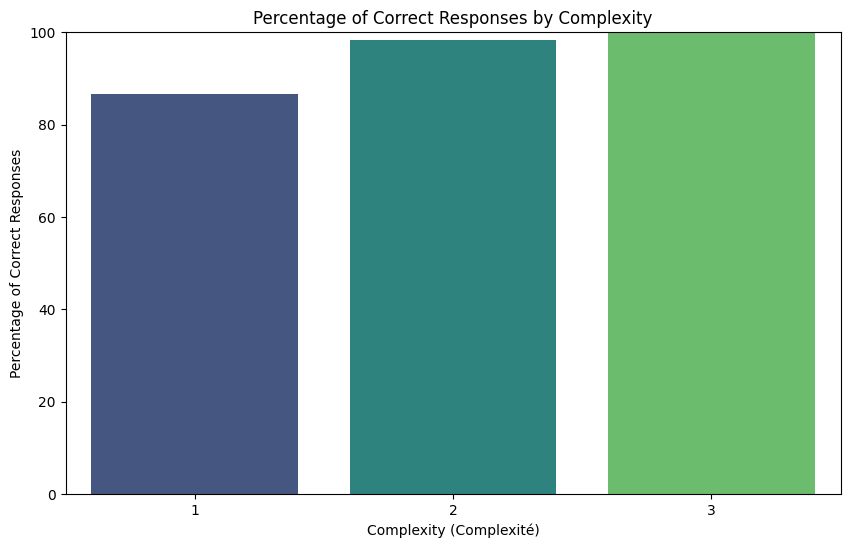

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate the percentage of correct responses by 'Complexité'
score_by_complexity = evaluatorDF.groupby('Complexité')['ScoreInt'].mean().reset_index()
score_by_complexity['ScoreInt'] *= 100  # Convert fraction to percentage

# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Complexité', y='ScoreInt', data=score_by_complexity, palette='viridis')
plt.title('Percentage of Correct Responses by Complexity')
plt.xlabel('Complexity (Complexité)')
plt.ylabel('Percentage of Correct Responses')
plt.ylim(0, 100)  # Set y-axis to show 0 to 100 for percentage
plt.show()

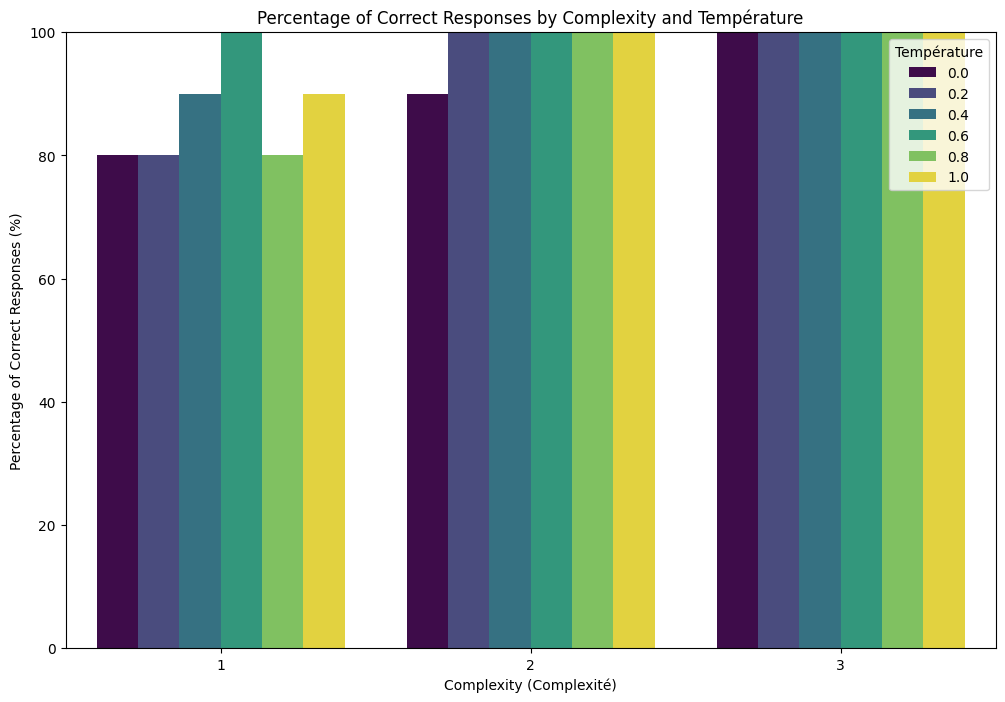

In [ ]:
# Assuming evaluatorDF is your DataFrame and it has columns for 'Complexité', 'Nb digits', and 'Score3'
# Calculate the percentage of correct responses by 'Complexité' and 'Température'
score_by_complexity_digits = evaluatorDF.groupby(['Complexité', 'Température'])['ScoreInt'].mean().reset_index()
score_by_complexity_digits['ScoreInt'] *= 100  # Convert fraction to percentage

# Plotting the results
plt.figure(figsize=(12, 8))
sns.barplot(x='Complexité', y='ScoreInt', hue='Température', data=score_by_complexity_digits, palette='viridis')
plt.title('Percentage of Correct Responses by Complexity and Température')
plt.xlabel('Complexity (Complexité)')
plt.ylabel('Percentage of Correct Responses (%)')
plt.ylim(0, 100)  # Set y-axis to show 0 to 100 for percentage
plt.legend(title='Température')
plt.show()

#### Score R0

C:\Users\p.beglin\AppData\Local\Temp\ipykernel_27612\2209384277.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Complexité', y='ScoreR0', data=score_by_complexity, palette='viridis')


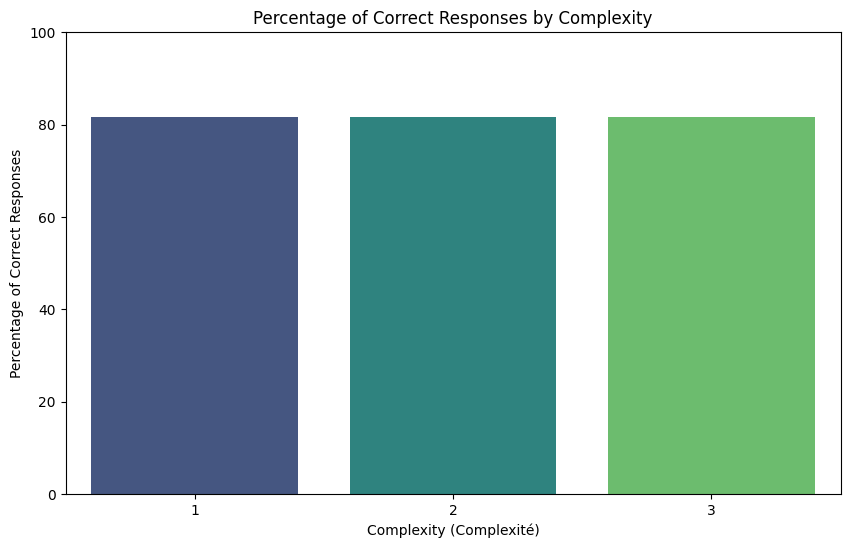

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate the percentage of correct responses by 'Complexité'
score_by_complexity = evaluatorDF.groupby('Complexité')['ScoreR0'].mean().reset_index()
score_by_complexity['ScoreR0'] *= 100  # Convert fraction to percentage

# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Complexité', y='ScoreR0', data=score_by_complexity, palette='viridis')
plt.title('Percentage of Correct Responses by Complexity')
plt.xlabel('Complexity (Complexité)')
plt.ylabel('Percentage of Correct Responses')
plt.ylim(0, 100)  # Set y-axis to show 0 to 100 for percentage
plt.show()

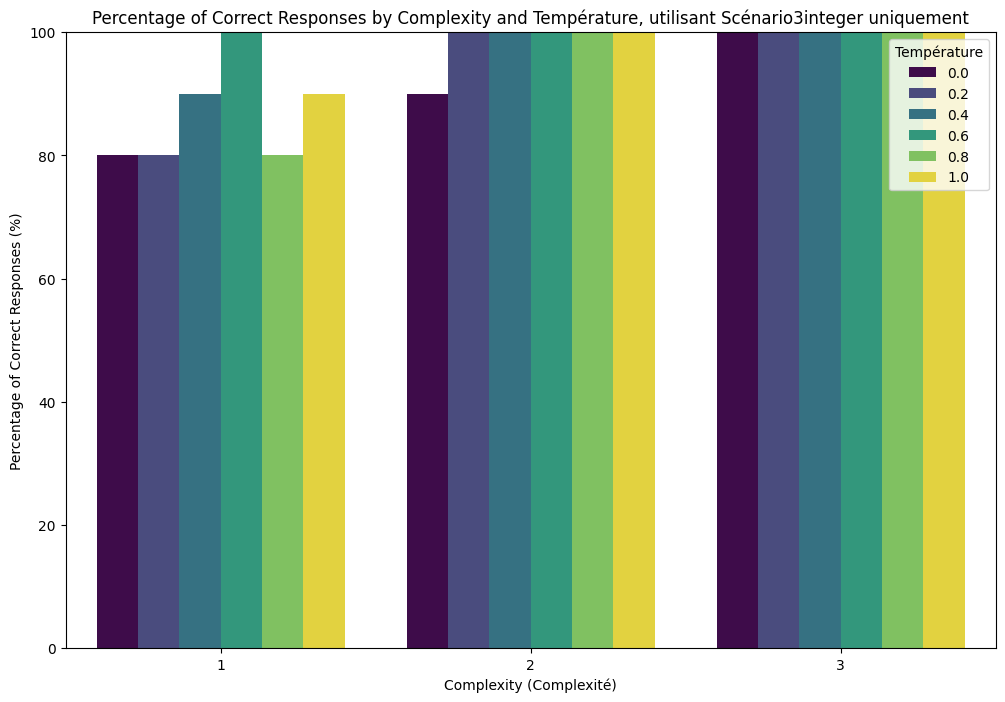

In [ ]:
# Assuming evaluatorDF is your DataFrame and it has columns for 'Complexité', 'Température', and 'Score3'
# Calculate the percentage of correct responses by 'Complexité' and 'Température'
score_by_complexiTempérature = evaluatorDF.groupby(['Complexité', 'Température'])['ScoreR0'].mean().reset_index()
score_by_complexiTempérature['ScoreR0'] *= 100  # Convert fraction to percentage

# Plotting the results
plt.figure(figsize=(12, 8))
sns.barplot(x='Complexité', y='ScoreR0', hue='Température', data=score_by_complexiTempérature, palette='viridis')
plt.title('Percentage of Correct Responses by Complexity and Température, utilisant Scénario3integer uniquement')
plt.xlabel('Complexity (Complexité)')
plt.ylabel('Percentage of Correct Responses (%)')
plt.ylim(0, 100)  # Set y-axis to show 0 to 100 for percentage
plt.legend(title='Température')
plt.show()